In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"https://raw.githubusercontent.com/SumanGouda/Machine-Learning-Projects/refs/heads/main/CAR%20PRICE%20PREDICTION/car_dataset.csv")
# df.drop(columns=['ID', 'Manufacturer', 'Model'], axis=1, inplace=True)

In [3]:
df.rename(columns={"Prod. year" : "year"}, inplace=True)

# <font color="cyan"><i>Data Cleaning and Pre processing</i></font>

### Cleaning the Price column 

In [4]:
# Normal cars (even very old/used ones) don’t realistically sell for less than $1000 (₹80k approx.) in structured datasets.

# Generallly car price with max value is 2000000, above it we are making to nan by assuming a data entry error 

df["Price"] = df["Price"].apply(lambda x: np.nan if x > 2000000 or x < 1000 else x)

In [5]:
df['Price'].isna().sum()

np.int64(2575)

In [6]:
import plotly.express as px
fig = px.box(df, x='Price', template='plotly_dark', color_discrete_sequence=['cyan'])
fig.update_layout(font_color='white')
fig.show()

In [7]:
df['Price'] = df.groupby('Model')['Price'].transform(
    lambda x: x.fillna(x.median())
)

In [8]:
fig = px.box(df, x='Price', template='plotly_dark', color_discrete_sequence=['pink'])
fig.update_layout(font_color='white')
fig.show()

In [9]:
df["Price"].isna().sum()    # 37

# Here there is still 45 rows with missing values because some car models have no valid price data at all. 

# So we will fill these rows with the median price of the entire dataset.
df["Price"] = df["Price"].fillna(df["Price"].median())
df["Price"].isna().sum()    

np.int64(0)

In [10]:
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

### Cleanign the Airbags columns 

In [10]:
# Airbags with 0 as value 
df[df['Airbags'] == 0].shape[0]

# Calculate the percentage values 0 in the airbag column
per_0 = df[df['Airbags'] == 0].shape[0] / df.shape[0]
print(f"Percentage of cars with 0 airbags : {per_0}")

# Since cars after 1990 with zero airbags is rare 
df['Airbags'] = df.apply(lambda row: np.nan if row['year'] > 1990 and row['Airbags'] == 0 else row['Airbags'], axis=1)

Percentage of cars with 0 airbags : 0.12501949368404636


##### Filling the missing airbags values with the int values based on the release year 

In [11]:
# According to the safety rules the minimum number of airbags changed over the years 

def fill_airbags(row):
    
    # This function will fill the zero valued Airbags cell with a specified number based on the production year 
    
    year = row['year']
    price = row['Price']
    airbags = row['Airbags']

    # If already present, keep it
    if pd.notna(airbags):
        return airbags
    
    # Before 1990 → rare, but default to 1 (not 0 everywhere)
    if year <= 1990:
        if price > 20000:  # luxury
            return 1
        else:  
            return 1   # give 1 instead of 0 to reduce imbalance
    
    # 1991–2000 → dual airbags common
    elif 1991 <= year <= 2000:
        return 2
    
    # 2001–2010 → side airbags became common
    elif 2001 <= year <= 2010:
        return 4
    
    # 2011–2020 → curtain + knee airbags widespread
    elif 2011 <= year <= 2020:
        return 6
    
    # 2021 onwards → 6 standard, premium 8+
    else:
        if price > 30000:
            return 8
        return 6

# Apply function
df['Airbags'] = df.apply(fill_airbags, axis=1)

# Calculate the percentage values 0 in the airbag column
per_0 = df[df['Airbags'] == 0].shape[0] / df.shape[0]
print(f"Percentage of cars with 0 airbags after applying the function : {per_0}")


Percentage of cars with 0 airbags after applying the function : 0.003274938919789988


In [12]:
fig = px.histogram(df, x='Airbags', template='plotly_dark', color_discrete_sequence=['cyan'])
fig.update_layout(font_color='white')
fig.show()

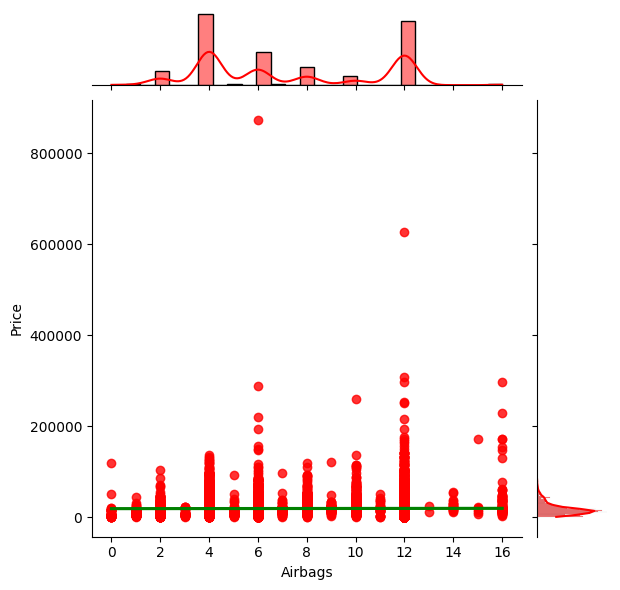

In [13]:
sns.jointplot(data=df, x='Airbags', y='Price', kind='reg', color='red', line_kws={'color': 'green'})
plt.show()

### Analysing the "Engine Volume' Column

In [14]:
# 1. FIRST: Create the 'Engine Type' column using the original string values
df['Engine Type'] = df['Engine volume'].apply(lambda x: 1 if 'Turbo' in str(x) else 0)

# 2. SECOND: Now clean the 'Engine volume' column by removing 'Turbo' and converting# Split the string by space and take the first part, then convert to float
df['Engine volume'] = df['Engine volume'].str.split().str[0].astype(float)

In [15]:
from plotly.subplots import make_subplots

# Store original data for comparison
original_engine_vol = df['Engine volume'].copy()

# Clean the data (properly)
df.loc[(df['Engine volume'] > 8) | (df['Engine volume'] < 0.6), 'Engine volume'] = np.nan

# Create subplots with dark theme
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Engine Volume Before Cleaning', 
                    'Engine Volume After Cleaning<br>(>8L values → NaN)')
)

# Add before cleaning boxplot
fig.add_trace(
    go.Box(y=original_engine_vol, name='Before', marker_color='cyan'),
    row=1, col=1
)

# Add after cleaning boxplot
fig.add_trace(
    go.Box(y=df['Engine volume'][df['Engine volume'].notna()], name='After', marker_color='lime'),
    row=1, col=2
)

# Update layout with dark theme
fig.update_layout(
    template='plotly_dark',
    title_text='Engine Volume Distribution: Before vs After Cleaning',
    title_x=0.5,
    font=dict(color='white'),
    showlegend=False,
    height=500
)

# Update y-axis labels
fig.update_yaxes(title_text='Liters', row=1, col=1)
fig.update_yaxes(title_text='Liters', row=1, col=2)

fig.show()

In [16]:
df['Engine volume'] = df.groupby('Cylinders')['Engine volume'].transform(
    lambda x: x.fillna(x.median())
)

# If there are any remaining NaNs, fill with overall median
df['Engine volume'] = df['Engine volume'].fillna(df['Engine volume'].median())

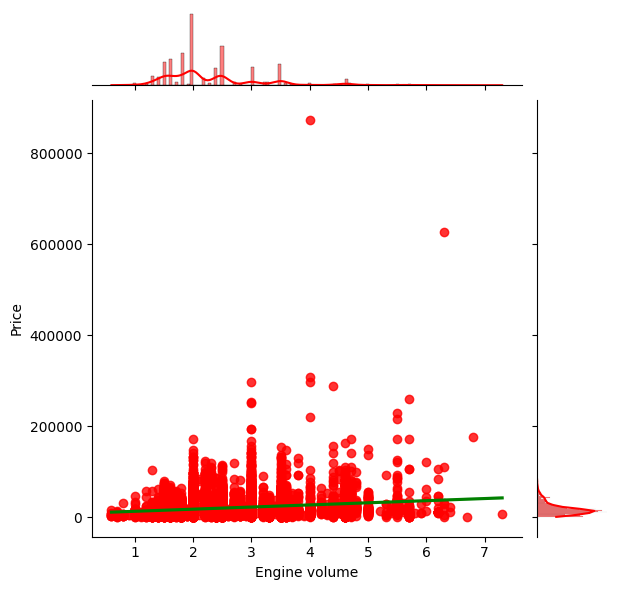

In [18]:
sns.jointplot(data=df, x='Engine volume', y='Price', kind='reg', color='red', line_kws={'color': 'green'})
plt.show()

In [17]:
df['Engine volume'].describe()

count    19237.000000
mean         2.311150
std          0.853073
min          0.600000
25%          1.800000
50%          2.000000
75%          2.500000
max          7.300000
Name: Engine volume, dtype: float64

In [18]:
df['Gear box type']

0        Automatic
1        Tiptronic
2         Variator
3        Automatic
4        Automatic
           ...    
19232       Manual
19233    Tiptronic
19234    Automatic
19235    Automatic
19236    Automatic
Name: Gear box type, Length: 19237, dtype: object

In [19]:
# Making the Gear Type column more to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Gear box type'], drop_first=False)

df = df.astype({col: 'int' for col in df.filter(like='Gear box type').columns})     # Makes the one-hot encoded columns to int type

# Leave binary columns as they are

### Cleaning the 'Leather interior' column 

In [20]:
# Converting the 'Leather interior' column to binary
df['Leather interior'] = df['Leather interior'].apply(lambda x: 1 if x == 'Yes' else 0)

### Working with the Driver Wheel column

In [21]:
# Map the type values into more redable way
drive_wheel_mapping = {
    '4x4': '4WD',
    'Front': 'FWD',
    'Rear': 'RWD'
}

df['Drive wheels'] = df['Drive wheels'].replace(drive_wheel_mapping)

# Applying the one- hot encoding
df = pd.get_dummies(df, columns=['Drive wheels'], drop_first=True)

df = df.astype({col: 'int' for col in df.filter(like='Drive wheels').columns})     # Makes the one-hot encoded columns to int type

### Working with the 'Wheel' column 

In [22]:
df['Wheel'].value_counts()

Wheel
Left wheel          17753
Right-hand drive     1484
Name: count, dtype: int64

In [23]:
# More robust conversion
def convert_wheel(x):
    x_str = str(x).strip().lower()
    if 'left' in x_str:
        return 1
    elif 'right' in x_str:
        return 0
    else:
        return x  # or return some default value

df['Wheel'] = df['Wheel'].apply(convert_wheel)

# Check results
print("After robust conversion:")
print(df['Wheel'].value_counts())

After robust conversion:
Wheel
1    17753
0     1484
Name: count, dtype: int64


### Cleaning the mileage column

In [24]:
# Cleaning the 'Mileage' column by removing 'km' and converting to integer
df['Mileage'] = df['Mileage'].str.replace('km', '').str.replace(',', '').astype(int)

# Count how many rows have the absurd maximum value
absurd_value = 2147483647
absurd_count = (df['Mileage'] == absurd_value).sum()
print(f"Number of rows with absurd mileage ({absurd_value}): {absurd_count}")
print(f"Percentage of total data: {(absurd_count / len(df)) * 100:.2f}%")

# Also, check for other very high values (e.g., over 1,000,000 km)
unreal_mileage = (df['Mileage'] < 100) | (df['Mileage'] > 500000).sum()
print(f"Number of rows with unrealistic mileage: {unreal_mileage}")
original_shape = df.shape

df.loc[(df['Mileage'] < 100) | (df['Mileage'] > 500000), 'Mileage'] = np.nan

print(f"Shape before cleaning: {original_shape}")
print(f"Shape after cleaning: {df.shape}")  # The shape should be THE SAME
print(f"Number of unrealistic mileage values converted to NaN: {df['Mileage'].isna().sum()}")

Number of rows with absurd mileage (2147483647): 7
Percentage of total data: 0.04%
Number of rows with unrealistic mileage: 0        True
1        True
2        True
3        True
4        True
         ... 
19232    True
19233    True
19234    True
19235    True
19236    True
Name: Mileage, Length: 19237, dtype: bool
Shape before cleaning: (19237, 23)
Shape after cleaning: (19237, 23)
Number of unrealistic mileage values converted to NaN: 983


In [25]:
# Group by relevant columns and fill NaN with the mode (most common value) of that group
df['Mileage'] = df.groupby(['Engine volume', 'Cylinders', 'Gear box type_Automatic', 'Gear box type_Manual', 'Gear box type_Tiptronic', 'Gear box type_Variator', 'Engine Type'])['Mileage'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(df['Mileage'].mode()[0])
)

# Check if there are any remaining NaNs and fill with overall mode
if df['Mileage'].isna().sum() > 0:
    overall_mode = df['Mileage'].mode()
    if not overall_mode.empty:
        df['Mileage'] = df['Mileage'].fillna(overall_mode[0])

In [26]:
        
df['Mileage'].isna().sum()

np.int64(0)

<Axes: xlabel='Mileage', ylabel='Density'>

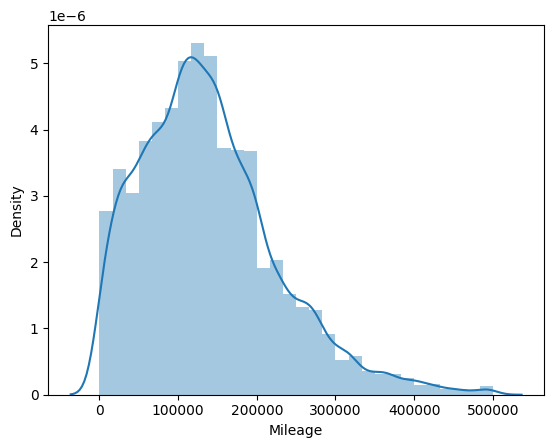

In [27]:
sns.distplot(df['Mileage'], bins=30, kde=True)

### Analysing the cylinder column 

In [28]:
df[df['Cylinders'] < 3]['Cylinders'] = np.nan
print(f"Number of rows with unrealistic 'Cylinders' values (<3): {df['Cylinders'].isna().sum()}")

# Applying the same technique as applied to the 'Mileage' column to fill these unusual 'Cylinders' values
df['Cylinders'] = df.groupby(['Gear box type_Automatic', 'Gear box type_Manual','Gear box type_Tiptronic', 'Gear box type_Variator', 'Engine Type'])['Cylinders'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(df['Cylinders'].mode()[0])
)

Number of rows with unrealistic 'Cylinders' values (<3): 0


<Axes: xlabel='Cylinders', ylabel='Density'>

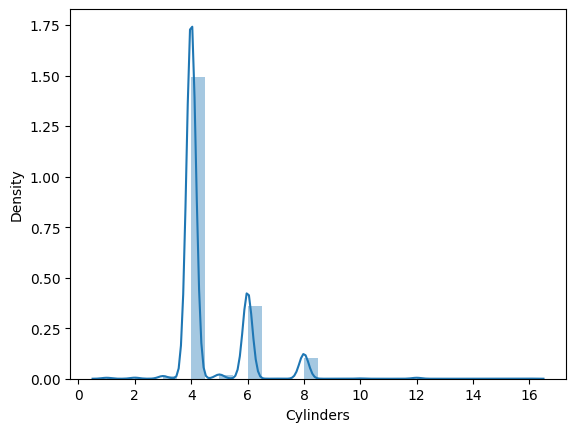

In [29]:
sns.distplot(df['Cylinders'], bins=30, kde=True)

### Applying the one hot encoding for the fuel type column 

In [30]:
fuel_dummies = pd.get_dummies(df['Fuel type'], drop_first=True, prefix='Fuel')

df = pd.concat([df, fuel_dummies], axis=1)

df.drop('Fuel type', axis=1, inplace=True)

In [ ]:
# Save df for another tree model 
df.to_csv('cleaned_car_dataset.csv', index=False)       # Do not run this code again on this system 

## Data Scaling 

In [32]:
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler

class ApplyTransformation:
    def __init__(self, x):
        self.x = x
        self.transformation_results = {}
        
    def apply_all_transformations(self):
        """Apply all transformations and plot in a grid layout"""
        transformations = {
            'Log Transform': self._apply_log(),
            'Yeo-Johnson': self._apply_yeo_johnson(),
            'Min-Max Scaling': self._apply_min_max_scaler(),
            'Standard Scaling': self._apply_standard_scaler(),
            'Square Transform': self._apply_square_transformer(),
            'Square Root Transform': self._apply_sqrt_transformer(),
            'Reciprocal Transform': self._apply_reciprocal_transformer()
        }
        
        # Try to add Box-Cox if possible
        try:
            transformations['Box-Cox'] = self._apply_box_cox()
        except ValueError:
            pass  # Skip Box-Cox if data has non-positive values
        
        self.transformation_results = transformations
        
        # Create grid layout
        n_transforms = len(transformations)
        n_cols = 2
        n_rows = (n_transforms + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        axes = axes.flatten()
        
        # Plot each transformation
        for i, (name, data) in enumerate(transformations.items()):
            ax = axes[i]
            sns.distplot(data, kde=True, ax=ax)
            ax.set_title(f'{name}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_facecolor('#f8f9fa')
            
        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout()
        plt.show()
        
        return transformations
    
    # Private methods for individual transformations (no plotting)
    def _apply_log(self):
        return np.log1p(self.x)
    
    def _apply_yeo_johnson(self):
        x_reshaped = self.x.values.reshape(-1, 1)
        x_transformed = power_transform(x_reshaped, method='yeo-johnson')
        return x_transformed.flatten()
    
    def _apply_box_cox(self):
        if (self.x <= 0).any():
            raise ValueError("Box-Cox transformation requires positive values")
        x_reshaped = self.x.values.reshape(-1, 1)
        x_transformed = power_transform(x_reshaped, method='box-cox')
        return x_transformed.flatten()
    
    def _apply_min_max_scaler(self):
        x_reshaped = self.x.values.reshape(-1, 1)
        scaler = MinMaxScaler()
        x_transformed = scaler.fit_transform(x_reshaped)
        return x_transformed.flatten()
    
    def _apply_standard_scaler(self):
        x_reshaped = self.x.values.reshape(-1, 1)
        scaler = StandardScaler()
        x_transformed = scaler.fit_transform(x_reshaped)
        return x_transformed.flatten()
    
    def _apply_square_transformer(self):
        return np.square(self.x)
    
    def _apply_sqrt_transformer(self):
        return np.sqrt(self.x)
    
    def _apply_reciprocal_transformer(self):
        return 1 / self.x
    
    # Individual public methods (with plotting) - kept for backward compatibility
    def apply_log(self):
        x_transformed = self._apply_log()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Log Transformation')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed
    
    def apply_yeo_johnson(self):
        x_transformed = self._apply_yeo_johnson()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Yeo-Johnson Transformation')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed
    
    def apply_box_cox(self):
        x_transformed = self._apply_box_cox()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Box-Cox Transformation')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed
    
    def min_max_scaler(self):
        x_transformed = self._apply_min_max_scaler()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Min-Max Scaling')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed
    
    def standard_scaler(self):
        x_transformed = self._apply_standard_scaler()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Standard Scaling')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed
    
    def square_transformer(self):
        x_transformed = self._apply_square_transformer()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Square Transformation')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed
    
    def sqrt_transformer(self):
        x_transformed = self._apply_sqrt_transformer()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Square Root Transformation')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed
    
    def reciprocal_transformer(self):
        x_transformed = self._apply_reciprocal_transformer()
        plt.figure()
        sns.distplot(x_transformed, kde=True)
        plt.title('Reciprocal Transformation')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.gca().set_facecolor('#f8f9fa')
        plt.show()
        return x_transformed

### Applying transformation for the Engine Volume column

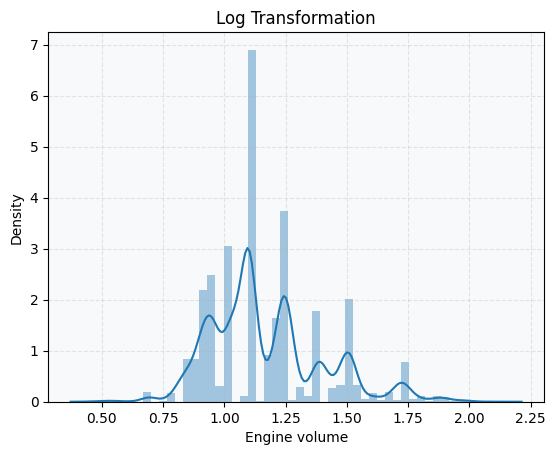

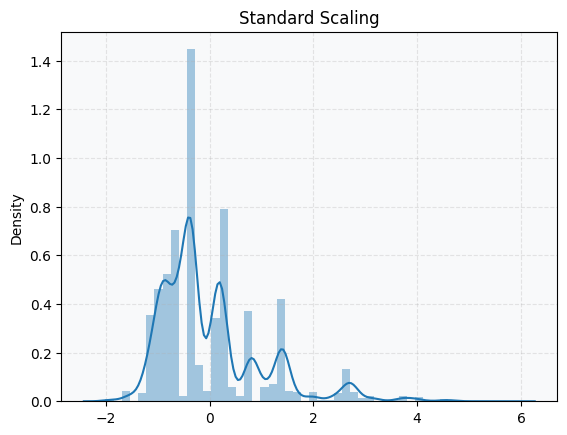

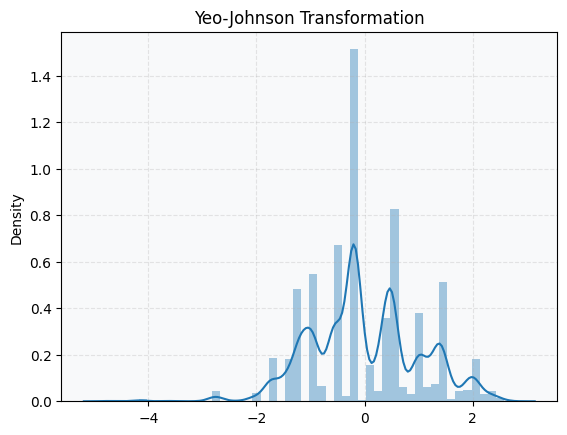

In [33]:
# Create transformer instance and apply over the 'Engine volume' column
copy_df = df.copy()
transformer = ApplyTransformation(copy_df['Engine volume'])

# Apply transformations
log_transformed = transformer.apply_log()   # It is giving the more normal output so we would go with this one 
standardized = transformer.standard_scaler()
x_yeojohnson = transformer.apply_yeo_johnson()

# Go wiht the Log transformation

In [34]:
df['Engine volume'] = log_transformed

### Applying transformation over the Mileage column

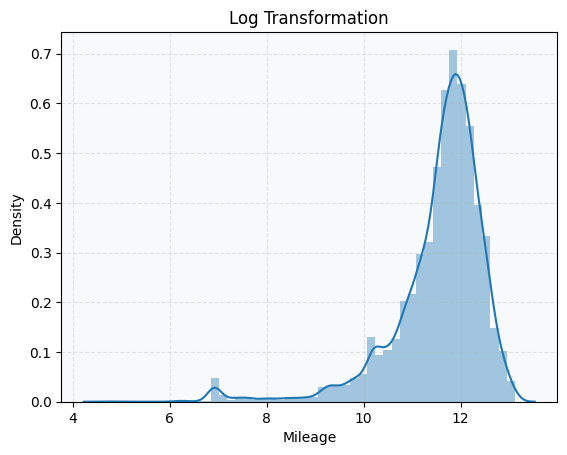

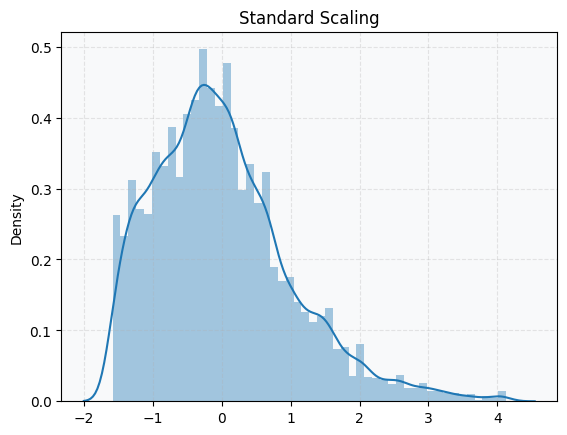

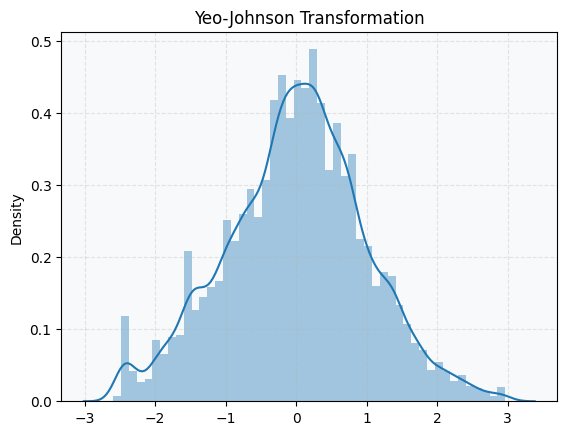

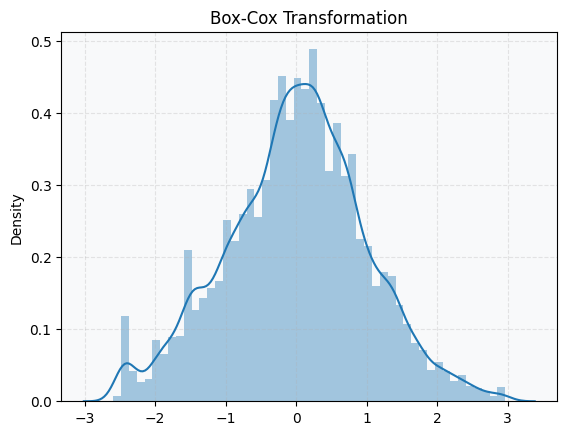

In [35]:
# Apply the transformation function over the 'Mileage' Column 

transformer = ApplyTransformation(copy_df['Mileage'])
log_transformed = transformer.apply_log()
standardized = transformer.standard_scaler()
x_yeojohnson = transformer.apply_yeo_johnson()
x_box_cox = transformer.apply_box_cox()

# Go with the Box-Cox transformation 

In [36]:
df['Mileage'] = x_box_cox

### Applying the transforamtion over the cylinders column

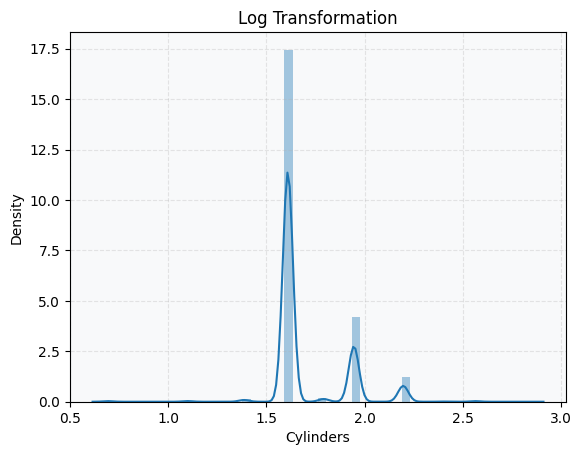

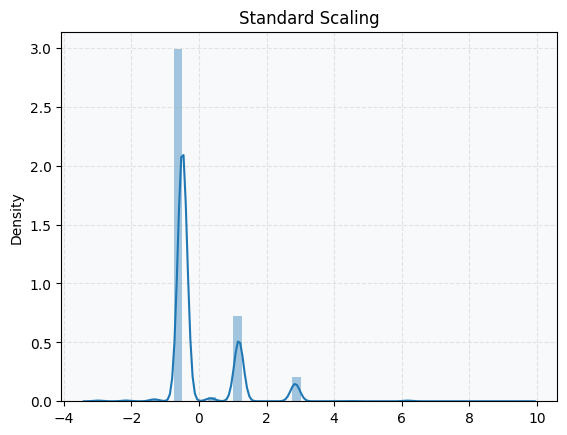

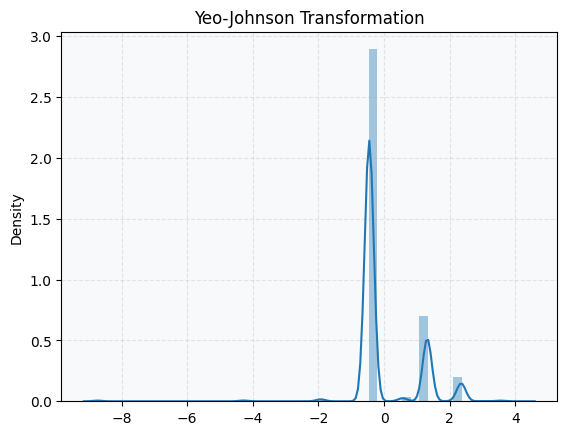

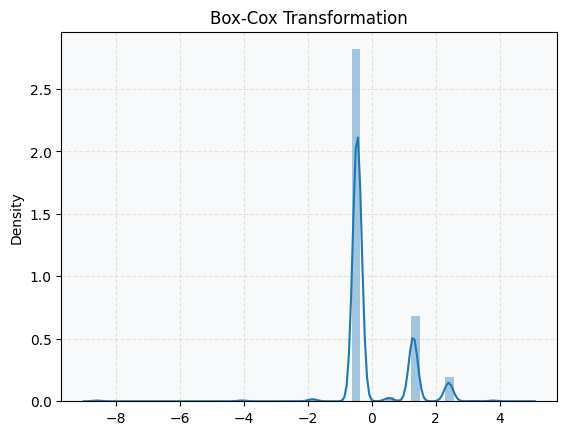

In [37]:
# Apply the transforamtion over the 'Cylinders' column'

transformer = ApplyTransformation(copy_df['Cylinders'])

log_transformed = transformer.apply_log()
standardized = transformer.standard_scaler()
x_yeojohnson = transformer.apply_yeo_johnson()
x_box_cox = transformer.apply_box_cox()

# We would not apply any scaling to this column

### Applying the transformation over the Airbags column 

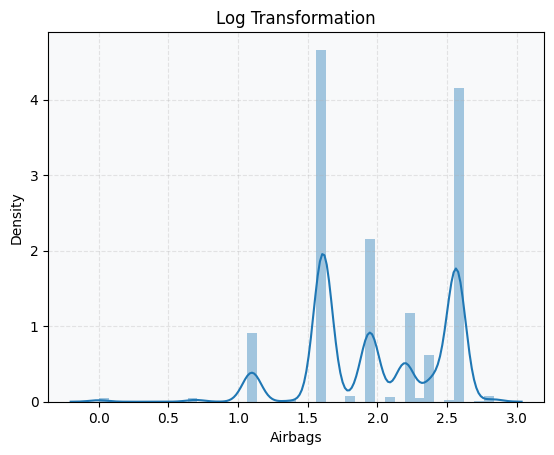

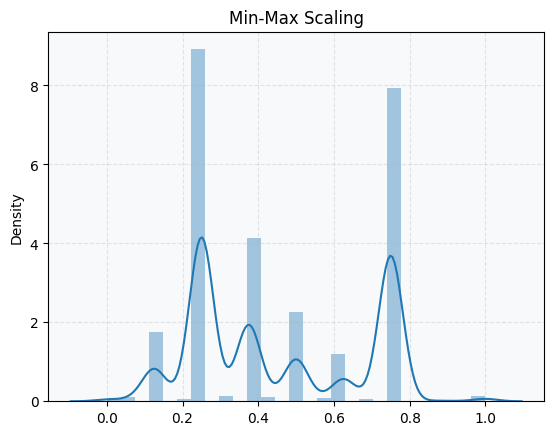

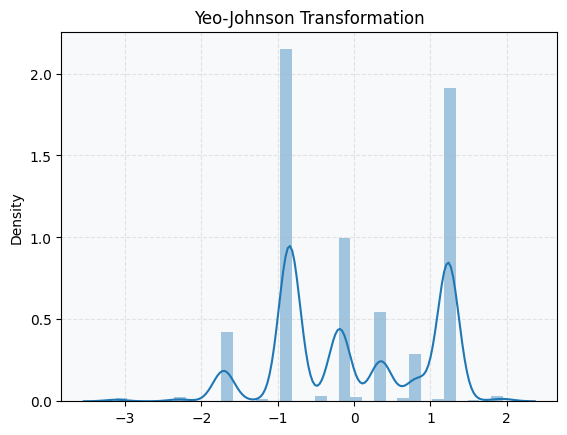

In [38]:
# Scaling the Airbags column 

transformer = ApplyTransformation(copy_df['Airbags'])

log_transformed = transformer.apply_log()
min_max = transformer.min_max_scaler()
x_yeojohnson = transformer.apply_yeo_johnson()

# Go with the Min-Max Scaling

In [39]:
df['Airbags'] = min_max

### Applying the transforamtion over the year column

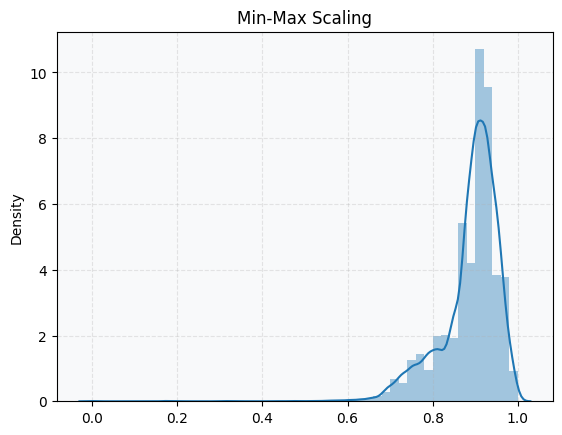

In [40]:
transformer = ApplyTransformation(copy_df['year'])

min_max = transformer.min_max_scaler()

df['year'] = min_max


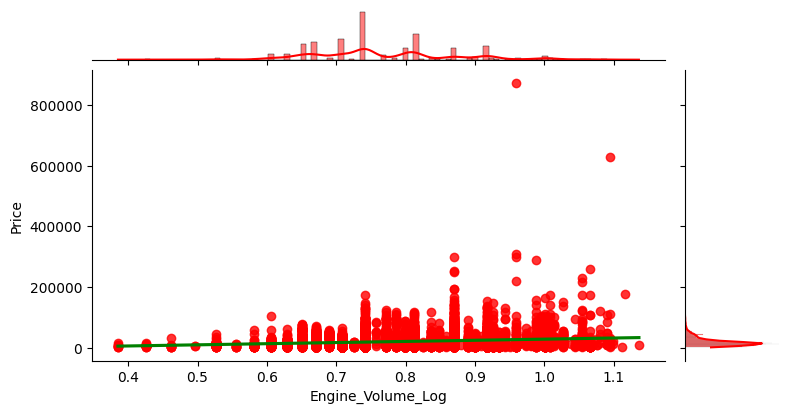

In [41]:
# Apply log transformation to engine volume
df['Engine_Volume_Log'] = np.log1p(df['Engine volume'])

# Create jointplot
fig = sns.jointplot(
    data=df, 
    x='Engine_Volume_Log', 
    y='Price', 
    kind='reg', 
    color='red', 
    line_kws={'color': 'green'}
)

# Adjust the figure size after creation
fig.fig.set_size_inches(8, 4)
plt.show()

## Data Pre-Processing 

In [42]:
df.head(3)

,ID,Price,Levy,Manufacturer,Model,year,Category,Leather interior,Engine volume,Mileage,...,Gear box type_Variator,Drive wheels_FWD,Drive wheels_RWD,Fuel_Diesel,Fuel_Hybrid,Fuel_Hydrogen,Fuel_LPG,Fuel_Petrol,Fuel_Plug-in Hybrid,Engine_Volume_Log
0,45654403,13328.0,1399,LEXUS,RX 450,0.876543,Jeep,1,1.504077,0.639693,...,0,0,0,False,True,False,False,False,False,0.917920
1,44731507,16621.0,1018,CHEVROLET,Equinox,0.888889,Jeep,0,1.386294,0.696627,...,0,0,0,False,False,False,False,True,False,0.869742
2,45774419,8467.0,-,HONDA,FIT,0.827160,Hatchback,0,0.832909,0.771346,...,1,1,0,False,False,False,False,True,False,0.605904


#### Working on the target column

In [43]:
df['Price'].describe()

count     19237.000000
mean      19409.015621
std       19039.694583
min        1000.000000
25%        9408.000000
50%       15053.000000
75%       23521.000000
max      872946.000000
Name: Price, dtype: float64

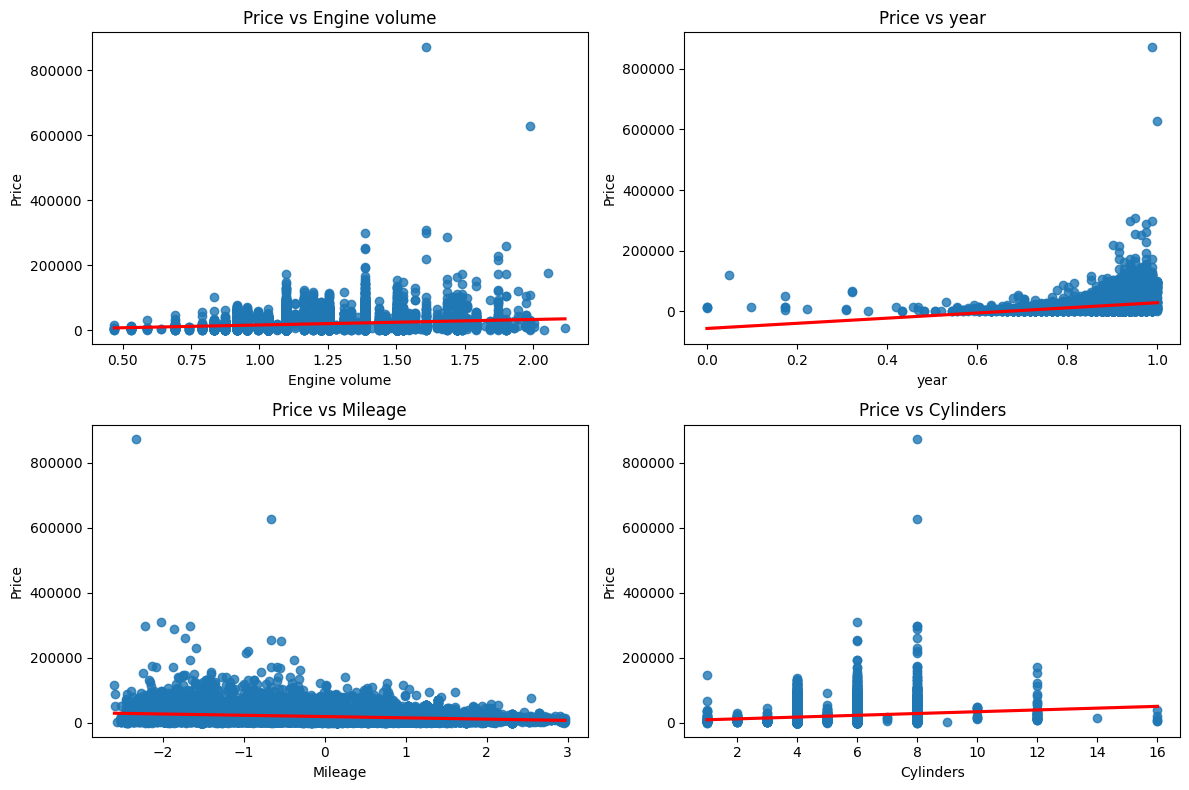

In [44]:
cols = ["Engine volume", "year", "Mileage", "Cylinders"]

# Create a grid: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  

for ax, col in zip(axes.flatten(), cols):
    sns.regplot(data=df, x=col, y="Price", ax=ax, line_kws={"color": "red"})
    ax.set_title(f"Price vs {col}")

plt.tight_layout()
plt.show()


## Making the linear model

In [58]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Category', 'Doors', 'Color'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying the lasso regression 

In [59]:
model = Lasso(alpha=0.9)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score is {r2:.4f}")

R2 Score is 0.2874


In [46]:
# # Calculate the error metrics
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# # Check the overfitting and underfitting error separetely
# mse_train = mean_squared_error(y_train, model.predict(X_train))
# rmse_train = np.sqrt(mse_train)
# r2_train = r2_score(y_train, model.predict(X_train))

# mse_test = mean_squared_error(y_test, model.predict(X_test))
# rmse_test = np.sqrt(mse_test)
# r2_test = r2_score(y_test, model.predict(X_test))

# print(f"Train RMSE: {rmse_train}")
# print(f"Train R-squared: {r2_train}")

# print(f"Test RMSE: {rmse_test}")
# print(f"Test R-squared: {r2_test}")

# print(f"Root Mean Squared Error: {rmse}")
# print(f"R-squared: {r2}")